<a href="https://colab.research.google.com/github/hyunj941031/Submit/blob/main/Project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# kaggle.json 업로드
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hyunjoonj","key":"2c8dd4e66767b14e1d4a20a989e2c513"}'}

In [7]:
ls -1ha kaggle.json

kaggle.json


In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d msambare/fer2013

 98% 59.0M/60.3M [00:02<00:00, 31.8MB/s]
100% 60.3M/60.3M [00:02<00:00, 23.4MB/s]


In [10]:
!ls

fer2013.zip			      kaggle.json      sample_data
haarcascade_frontalface_alt_tree.xml  my_model5876.h5


In [11]:
!unzip /content/fer2013.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating: train/sad/Tra

In [12]:
# haarcascade 파일 업로드
files.upload();

Saving haarcascade_frontalface_alt2.xml to haarcascade_frontalface_alt2.xml


In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
batch_size = 128
img_height = 128
img_width = 128

In [15]:
train_generator = train_datagen.flow_from_directory(
    '/content/train/',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    
    color_mode='grayscale',
    class_mode='sparse',
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    '/content/test/',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='sparse',
    shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [16]:
len(train_generator.classes)

28709

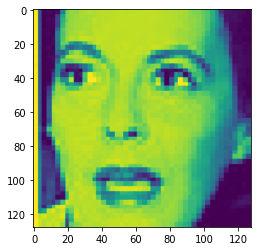

In [17]:
import cv2
import matplotlib.pyplot as plt

img, lbl = train_generator.next()
plt.imshow(img[1][:,:,0])

In [105]:
lbl[1]

3.0

In [91]:
from keras import models, layers
from keras import Input
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
 
import os
import matplotlib.pyplot as plt
import numpy as np
import math

K = 7
 
 
input_tensor = Input(shape=(128, 128, 1), dtype='float32', name='input')
 
 
def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   
 
    
 
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
 
    shortcut = x
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x
 
 
 
def conv3_layer(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
 
 
def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x
 
 
 
def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x
 
 
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
# x = conv5_layer(x)
 
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
output_tensor = Dense(K, activation='softmax')(x)
 
model = Model(input_tensor, output_tensor)

In [92]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [93]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, mode = 'auto')

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    batch_size=batch_size,
    epochs=100,
    callbacks = [early_stopping],
    verbose=1
)

Epoch 1/100
225/225 [==============================] - 99s 414ms/step - loss: 1.8671 - accuracy: 0.2824 - val_loss: 1.8795 - val_accuracy: 0.1715
Epoch 2/100
225/225 [==============================] - 92s 411ms/step - loss: 1.4384 - accuracy: 0.4428 - val_loss: 1.6219 - val_accuracy: 0.3571
Epoch 3/100
225/225 [==============================] - 92s 409ms/step - loss: 1.2501 - accuracy: 0.5210 - val_loss: 1.7579 - val_accuracy: 0.3583
Epoch 4/100
225/225 [==============================] - 92s 409ms/step - loss: 1.1597 - accuracy: 0.5600 - val_loss: 1.4701 - val_accuracy: 0.4674
Epoch 5/100
225/225 [==============================] - 92s 409ms/step - loss: 1.0995 - accuracy: 0.5848 - val_loss: 1.3772 - val_accuracy: 0.4749
Epoch 6/100
225/225 [==============================] - 92s 408ms/step - loss: 1.0440 - accuracy: 0.6078 - val_loss: 1.2375 - val_accuracy: 0.5515
Epoch 7/100
225/225 [==============================] - 92s 408ms/step - loss: 1.0042 - accuracy: 0.6184 - val_loss: 1.3312 -

In [94]:
model.save('/content/my_modellast.h5')

In [109]:
files.download('my_modellast.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
from google.colab import files
files.upload();

Saving my_model5876.h5 to my_model5876.h5


In [4]:
from keras.models import load_model
model = load_model('my_model5876.h5')

In [29]:
scores = model.evaluate_generator(validation_generator, steps=10)
print(model.metrics_names[1],' : ', scores[1]*100)

<ipython-input-29-32b606f85f3f>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(validation_generator, steps=10)


accuracy  :  59.687501192092896


In [19]:
# 이미지 업로드
files.upload();

Saving images.jpg to images.jpg


In [20]:
import os

os.mkdir('raw_image')

In [21]:
os.mkdir('cropped_img')

In [24]:
import cv2
import numpy as np
import matplotlib.image as img
import os

test_image = img.imread('/content/raw_image/images.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
print(test_image.shape)
test_image = cv2.resize(test_image, (128, 128))
print(test_image.shape)
test_images = np.array([test_image])
# for _ in range(30):
#     test_images.append(test_image)
# test_images = np.array(test_images)
oh_label = model.predict(test_images)[0]

(183, 275)
(128, 128)
1/1 [==============================] - 1s 859ms/step


neutral


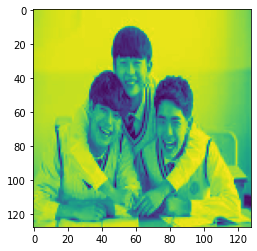

In [25]:
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
for i in range(7):
    if oh_label[i]:
        plt.imshow(test_image)
        print(classes[i])

In [108]:
files.upload();

Saving haarcascade_frontalface_alt2.xml to haarcascade_frontalface_alt2.xml


1/1 [==============================] - 0s 54ms/step


array([[0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

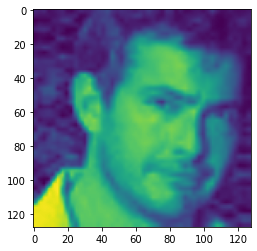

In [26]:
sam = img.imread('/content/train/angry/Training_10120469.jpg')
sam = cv2.resize(sam, (128, 128))
sam = np.array(sam)
sam = np.expand_dims(sam, axis=0)
plt.imshow(sam[0])
model.predict(sam)

1/1 [==============================] - 0s 96ms/step
[0. 0. 0. 0. 1. 0. 0.]
1/1 [==============================] - 0s 132ms/step
[0. 0. 0. 0. 1. 0. 0.]


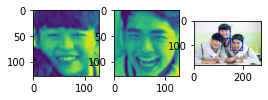

In [27]:
# 이미지 자르기
import cv2
import numpy as np
import matplotlib.image as img
import os

cascade_file = '/content/haarcascade_frontalface_alt2.xml'
cascade = cv2.CascadeClassifier(cascade_file)

red = (0,0,255)
green = (0, 255, 0)
font = cv2.FONT_HERSHEY_PLAIN

classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

raw_image_path = '/content/raw_image/'
raw_image_data = []
a = 1
plt.figure(figsize=(7,7))
for filename in os.listdir(raw_image_path):
    if 'jpg' not in filename:
        continue
    image = img.imread(raw_image_path + filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)
    face_list = cascade.detectMultiScale(gray)
    justfilename = filename.split('.')[0]
    temp = gray.copy()
    result_image = image.copy()

    for (x,y,w,h) in face_list:
        plt.subplot(5, 5, a)
        result_image = cv2.rectangle(result_image, (x, y), (x+w, y+h), red, 2)
        cropped_img = gray[y:y+h, x:x+w]
        cropped_img = cv2.resize(cropped_img, (128, 128))
        cropped_img = np.array([cropped_img])
        plt.imshow(cropped_img[0])
        pred = model.predict(cropped_img)[0]
        print(pred)
        for i in range(7):
            if pred[i]:
                text = classes[i]
                break
        result_image = cv2.putText(result_image, text, (x,y), font, 1, green, 1)
        a += 1
    plt.subplot(5,5,a)
    plt.imshow(result_image)
    result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
    file_str = f'/content/cropped_img/cropped_{filename}'
    cv2.imwrite(file_str, result_image)
    a += 1
plt.show()